<a href="https://colab.research.google.com/github/ishaan10dutta/Time-Series-Forecasting-Analysis-Ensemble-in-Python/blob/master/3_LSTM__GRU_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Forecasting using accuracy as the metric

In the previous notebooks, I used MAE as the measurement metric. Here, I have changed used accuracy as a measure by changing the regression problem into classification. I found how I could predict datapoints of the closing price by creating EMA, normalizing the dataset and stacking X(OHLCV) and finding Y based on X.

I then used this dataset to split into test, train and validation datasets.

I stacked the OHLCV data and used that as X and closing prices as Y hence converted the regression to a classification problem, and predicted the accuacy.

I have also used hyperparemeter tuning for the LSTM model and ran a GRU cell for comparison as well.

##Setting up

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
googlepath = "/content/drive/My Drive/"

In [7]:
from google.colab import files
src = list(files.upload().values())[0]

Saving python_utils-2.4.0-py2.py3-none-any.whl to python_utils-2.4.0-py2.py3-none-any.whl


In [8]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [9]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
link = 'https://drive.google.com/open?id=1Qq9A3hV-x7D4R9lDG178_z0VeEj7c9Gi'
fluff, id = link.split('=')

In [11]:
import numpy as np
import pandas as pd

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')  
data_df = pd.read_csv('AMZN.csv')[::-1]

In [12]:
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data Preprocessing

This is how I decided to go forward, now that the data has been prepared satisfactorilt-

1. Create train for close price and add forecast for output price.

2. Not taking into consideration any tickers, unlike the in former models.

4. Creating a close price threshold, to create our a custom threshold indicator.

In [13]:
def shuffle_in_unison(a, b):
  assert len(a) == len(b)
  shuffled_a = np.empty(a.shape, dtype=a.dtype)
  shuffled_b = np.empty(b.shape, dtype=b.dtype)
  permutation = np.random.permutation(len(a))
  for old_index, new_index in enumerate(permutation):
    shuffled_a[new_index] = a[old_index]
    shuffled_b[new_index] = b[old_index]
  return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
  p = int(len(X) * percentage)
  X_train = X[0:p]
  Y_train = y[0:p]
  X_train, Y_train = shuffle_in_unison(X_train, Y_train)
  
  X_test = X[p:]
  Y_test = y[p:]
  
  return X_train, X_test, Y_train, Y_test

 

def remove_nan_examples(data):
  newX = []
  for i in range(len(data)):
    if np.isnan(data[i]).any() == False:
      newX.append(data[i])
  return newX

In [15]:
#converting all OHLCV data into list formats so appending will be easy
openp = data_df.loc[:, 'Open'].tolist()  
highp = data_df.loc[:, 'High'].tolist()
lowp = data_df.loc[:, 'Low'].tolist()
closep = data_df.loc[:, 'Close'].tolist()
volumep = data_df.loc[:, 'Volume'].tolist()


WINDOW = 30   #keeping a window of 30 days for EMA
EMB_SIZE = 5  
STEP = 1
FORECAST = 1 #one day forecast  
X, Y = [], []
for i in range(0, len(data_df), STEP):  #creating a counter for data with step size 1
    try:
        o = openp[i:i+WINDOW]  #declaring a window and sample through each stock price
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)  # normalizing the stock values by finding difference in array lenth and mean and dividing by stdev
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]           #creating train for close price
        y_i = closep[i+WINDOW+FORECAST]    #adding forecast for output price

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close: 
            y_i = [1, 0]              #label when closing price increases     
        else:
            y_i = [0, 1]              #label when closing price decreases

        x_i = np.column_stack((o, h, l, c, v))   

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))  #reshaping train to LSTM network requirements
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))


##LSTM MODEL

In [21]:
from keras import backend as K 
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [22]:
model = build_model(X_train, output_size=2, neurons = 32) #model output is next price normalised to 10th previous closing price

history = model.fit(X_train, Y_train,
                            epochs=50, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/50
8/8 [==============================] - 0s 44ms/step - loss: 0.5004 - accuracy: 0.4915 - mean_pred: 0.0469 - val_loss: 0.4978 - val_accuracy: 0.4464 - val_mean_pred: 0.0529
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4938 - accuracy: 0.5070 - mean_pred: 0.0628 - val_loss: 0.4967 - val_accuracy: 0.4598 - val_mean_pred: 0.0658
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4902 - accuracy: 0.5269 - mean_pred: 0.0890 - val_loss: 0.4956 - val_accuracy: 0.4732 - val_mean_pred: 0.0914
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4869 - accuracy: 0.5418 - mean_pred: 0.1307 - val_loss: 0.4892 - val_accuracy: 0.5223 - val_mean_pred: 0.1564
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4762 - accuracy: 0.5572 - mean_pred: 0.2126 - val_loss: 0.4765 - val_accuracy: 0.5446 - val_mean_pred: 0.2617
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4669 - accuracy: 

The model shows a training accuracy of 69% presently.

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [24]:
acc = model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

14/14 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.6652 - mean_pred: 0.3896
Test accuracy: [0.3686782419681549, 0.6651785969734192, 0.38957691192626953]


As for test accuracy, the model is currently at 66%.

###Evaluation of initial model

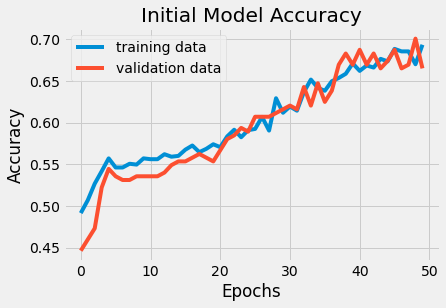

In [28]:
#Plotting training loss vs validation loss
plt.plot(history.history['accuracy'], label = 'training data')
plt.plot(history.history['val_accuracy'], label = 'validation data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Initial Model Accuracy')
plt.show()

A pretty decent model, all things considered. 

Normalized values difference is at 0.025, so there isn't much overfitting.

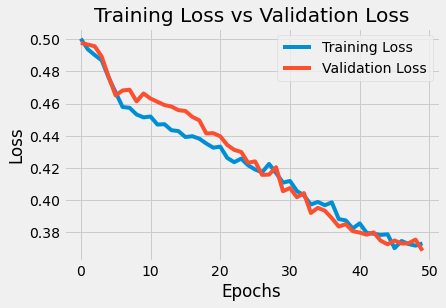

In [29]:
#Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

This initial LSTM model gives great results compared to pure stock prediction and even the previously simple moving average algorithm I used. 

I will now try to find the best LSTM model by tweaking epoch, cost function, actvation function and other parameters. 


##Hyperparameter Tuning

I plan to tune the LSTM model to the best version by: 

* Changing activation function and cost function
 
 elu with rmsprop and sgd along with mse and logcosh

* Trying for more epochs

* Initializers of random uniform and zeros


###Elu with mse and rmsprop

In [30]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="elu",
                dropout=0.10, loss="mse", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [31]:
model = build_model(X_train, output_size=2, neurons = 32)

history = model.fit(X_train, Y_train,
                            epochs=100, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/100
8/8 [==============================] - 0s 44ms/step - loss: 0.4576 - accuracy: 0.5299 - mean_pred: 0.0472 - val_loss: 0.4005 - val_accuracy: 0.5848 - val_mean_pred: 0.1150
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3596 - accuracy: 0.5428 - mean_pred: 0.1861 - val_loss: 0.2915 - val_accuracy: 0.5357 - val_mean_pred: 0.3133
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2691 - accuracy: 0.5473 - mean_pred: 0.3974 - val_loss: 0.2510 - val_accuracy: 0.5357 - val_mean_pred: 0.4773
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2505 - accuracy: 0.5448 - mean_pred: 0.4882 - val_loss: 0.2480 - val_accuracy: 0.5357 - val_mean_pred: 0.4959
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2490 - accuracy: 0.5488 - mean_pred: 0.4963 - val_loss: 0.2473 - val_accuracy: 0.5357 - val_mean_pred: 0.4887
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2492 - accu

The training accuracy has improved to around 72%, which is not a significant increase.

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [33]:
acc = model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

14/14 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.7098 - mean_pred: 0.4970
Test accuracy: [0.19307616353034973, 0.7098214030265808, 0.4969824254512787]


The testing accuracy is at 71%.

####Evaluation

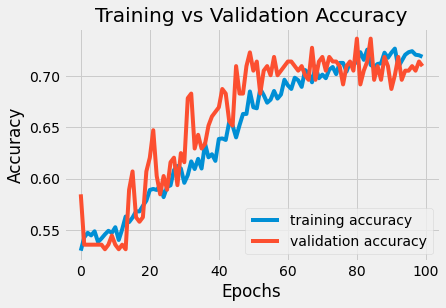

In [34]:
#Accuracy
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

The model may be slightly overfit, but that is expected after training for 100 epochs.

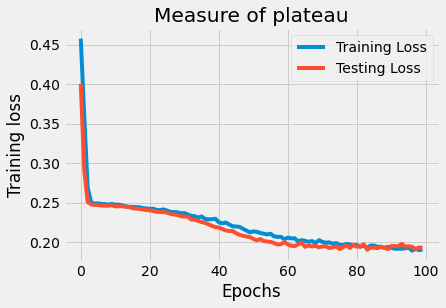

In [35]:
#Loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

#GRU MODEL

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. 

GRUs do not have cell states and use the hidden state to transfer information. 

A GRU network also only has two gates, a reset gate and update gate.

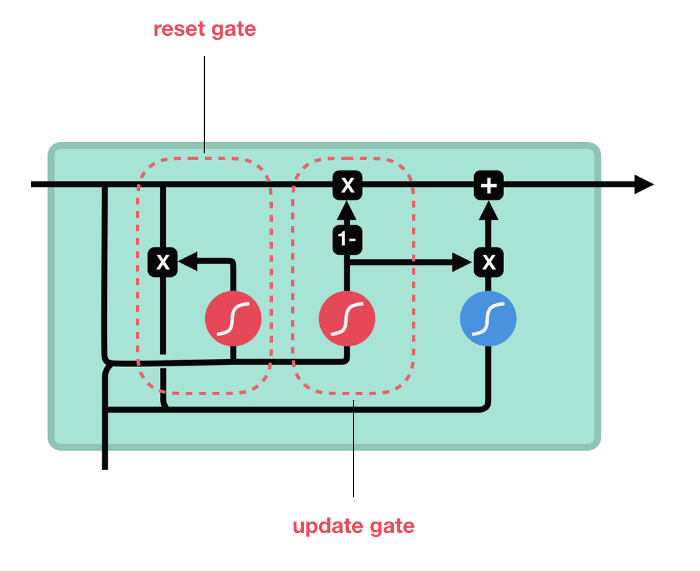

The two gates in a GRU network are:

* Update Gate
  
  The update gate acts similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add.

* Reset Gate
  
  The reset gate is another gate is used to decide how much past information to forget.

In [36]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(GRU(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [37]:
model = build_model(X_train, output_size=2, neurons = 32)

history = model.fit(X_train, Y_train,
                            epochs=50, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/50
8/8 [==============================] - 0s 42ms/step - loss: 0.4974 - accuracy: 0.4701 - mean_pred: 0.1095 - val_loss: 0.5006 - val_accuracy: 0.4598 - val_mean_pred: 0.1049
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4954 - accuracy: 0.4886 - mean_pred: 0.1022 - val_loss: 0.5010 - val_accuracy: 0.4375 - val_mean_pred: 0.0938
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4940 - accuracy: 0.4821 - mean_pred: 0.1042 - val_loss: 0.5005 - val_accuracy: 0.4554 - val_mean_pred: 0.1026
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4905 - accuracy: 0.4891 - mean_pred: 0.1221 - val_loss: 0.4990 - val_accuracy: 0.4688 - val_mean_pred: 0.1213
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4884 - accuracy: 0.5134 - mean_pred: 0.1363 - val_loss: 0.4936 - val_accuracy: 0.4866 - val_mean_pred: 0.1303
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4825 - accuracy: 

The GRU Model shows an initial training accuracy of 71%, which is a tad bit better than the LSTM which got 69%, with the same loss function, optimizer, and epochs.

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3744      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 3,810
Trainable params: 3,810
Non-trainable params: 0
_________________________________________________________________


In [40]:
acc = model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

14/14 [==============================] - 0s 3ms/step - loss: 0.3582 - accuracy: 0.7277 - mean_pred: 0.3973
Test accuracy: [0.35818010568618774, 0.7276785969734192, 0.3973040282726288]


The testing accuracy is at 72%.

###Evaluation 

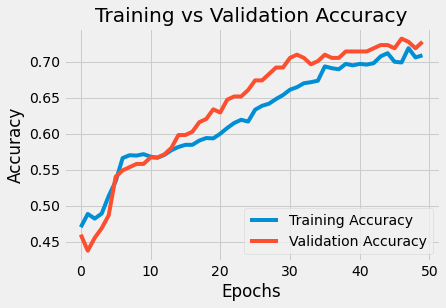

In [42]:
#Plotting training loss and validation accuracy
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

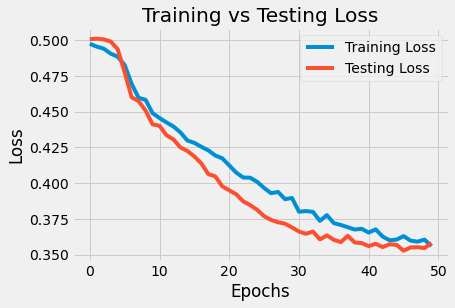

In [43]:
#Loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.show()

#Conclusion

The powerful LSTM and GRU architechtures work really well on the stacked OHLCV values, for prediction of future stock prices.

I achieved the best testing loss of 72%, after normalizing the data, stacking input data and performing hyperparameter tuning.